<a href="https://colab.research.google.com/github/BEMiklos/PlantTraits2024/blob/main/train_baselines_sceleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle
!pip install -q albumentations

Create New API Token and add it as kaggle.json to root

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c planttraits2024

100% 3.49G/3.50G [00:47<00:00, 55.9MB/s]
100% 3.50G/3.50G [00:47<00:00, 78.6MB/s]


In [4]:
!unzip '/content/planttraits2024.zip'

A streamkimeneten csak az utolsó 5000 sor látható.
  inflating: train_images/196423534.jpeg  
  inflating: train_images/196423707.jpeg  
  inflating: train_images/196423993.jpeg  
  inflating: train_images/196424200.jpeg  
  inflating: train_images/196424210.jpeg  
  inflating: train_images/196424213.jpeg  
  inflating: train_images/196424291.jpeg  
  inflating: train_images/196424430.jpeg  
  inflating: train_images/196424593.jpeg  
  inflating: train_images/196424666.jpeg  
  inflating: train_images/196424802.jpeg  
  inflating: train_images/196424812.jpeg  
  inflating: train_images/196424938.jpeg  
  inflating: train_images/196425178.jpeg  
  inflating: train_images/196425491.jpeg  
  inflating: train_images/196425781.jpeg  
  inflating: train_images/196426308.jpeg  
  inflating: train_images/196426979.jpeg  
  inflating: train_images/196427019.jpeg  
  inflating: train_images/196427071.jpeg  
  inflating: train_images/196427085.jpeg  
  inflating: train_images/196427243.jpeg  
  i

In [32]:
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import albumentations as A
import cv2

import torch
from torch import nn
import torch.nn.functional as F
from torchvision.io import read_image
from torch.utils.data import Dataset, ConcatDataset, DataLoader, Subset, random_split
from torchvision import transforms

from sklearn.model_selection import train_test_split

import re

In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
random_state = 7

np.random.seed(0)

random.seed(0)

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [7]:
TRAIN_IMAGES_PATH = '/content/train_images'
TEST_IMAGES_PATH = '/content/test_images'

# Untility functions

In [8]:
mean_pattern = r'X\d+_mean'
sd_pattern = r'X\d+_sd'

In [9]:
def find_matching_elements(lst,pattern):
    matching_elements = [element for element in lst if re.search(pattern, element)]
    return matching_elements

In [10]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [ ]:
train_df.sample(10)

,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,X18_mean,X26_mean,X50_mean,X3112_mean,X4_sd,X11_sd,X18_sd,X26_sd,X50_sd,X3112_sd
24886,184873835,-1.032917,574.295227,90.252380,62.482738,1227.480225,42.762859,87,144,125,...,0.174163,0.645791,0.433834,615.749773,NaN,NaN,NaN,NaN,NaN,NaN
31965,190494649,0.440794,589.538086,48.000000,33.024284,1090.136475,39.804287,54,149,118,...,0.554565,1.121493,1.130741,725.767936,0.002047,0.909884,0.073212,0.059998,0.042375,30.941051
28421,195642066,17.284445,341.909515,65.457146,89.490135,544.396545,31.776667,138,163,151,...,0.439074,0.601914,1.030841,304.821680,0.003821,0.326769,0.027901,0.153138,0.013564,16.485387
12674,164426751,12.075297,166.142853,24.500000,49.969826,902.658264,38.064285,129,148,141,...,0.199941,3.176854,2.202036,509.618373,NaN,NaN,NaN,NaN,NaN,NaN
31158,186882920,17.013542,1030.795898,266.556122,91.027039,177.292847,14.822959,107,117,112,...,0.231805,0.051018,1.190324,89.976644,0.005543,0.221099,0.025756,0.024287,0.015604,5.421096
45443,195637432,-0.526925,317.861908,87.438095,113.449104,1096.622192,40.898571,108,146,128,...,0.359241,1.062527,1.332752,3322.765956,NaN,NaN,NaN,NaN,NaN,NaN
19727,194871319,20.958969,2068.119141,264.828583,53.143101,488.990204,19.647144,115,144,128,...,0.232182,0.041521,2.149017,669.891966,NaN,NaN,NaN,NaN,NaN,NaN
20600,186386731,18.402203,563.590454,81.157143,64.466095,437.827026,24.329046,121,136,131,...,0.230897,0.500619,0.942541,608.056653,NaN,NaN,NaN,NaN,NaN,NaN
24052,164361896,17.402231,870.571411,82.178574,35.694508,825.165405,35.850002,148,174,162,...,0.283748,0.163265,1.672265,62.625917,NaN,NaN,NaN,NaN,NaN,NaN
35949,195065314,11.712444,437.182220,34.533333,28.756390,632.724487,29.993334,127,155,137,...,0.009491,0.147462,1.895993,9.095304,0.005892,0.749986,0.000848,0.008639,0.137162,1.257774


In [ ]:
len(train_df.columns), len(test_df.columns)

(176, 164)

In [ ]:
len(train_df), len(test_df)

(55489, 12746)

In [11]:
targets = [col for col in train_df.columns if col not in test_df.columns]

In [12]:
metadata_columns = [col for col in train_df.columns if col in test_df.columns and col != 'id']

 TODO: hiányzó értékek kezelésének pontosítása

In [ ]:
# Check for missing values in the train DataFrame
train_missing_values = train_df.isnull().sum()
print("Missing values in Train DataFrame:")
print(train_missing_values)

Missing values in Train DataFrame:
id                                                                           0
WORLDCLIM_BIO1_annual_mean_temperature                                       0
WORLDCLIM_BIO12_annual_precipitation                                         0
WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month        0
WORLDCLIM_BIO15_precipitation_seasonality                                    0
                                                                         ...  
X11_sd                                                                   16341
X18_sd                                                                   16341
X26_sd                                                                   16341
X50_sd                                                                   16341
X3112_sd                                                                 16341
Length: 176, dtype: int64


In [ ]:
train_df.fillna(train_df.mean(), inplace=True)

# Augmentation

In [ ]:
class AlbumentationsTransform:
    def __init__(self, augmentation):
        self.augmentation = augmentation

    def __call__(self, img):
        img_np = np.array(img)
        augmented = self.augmentation(image=img_np)
        return augmented['image']

train_augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=45, p=0.5),
    A.RandomResizedCrop(height=256, width=256, scale=(0.8, 1.0), p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02, p=0.2),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.2),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),
    A.GaussianBlur(blur_limit=3, p=0.5),
    A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.5),
    A.CoarseDropout(max_holes=8, max_height=8, max_width=8, min_holes=2, fill_value=0, p=0.5),
    A.Sharpen(alpha=0.3, lightness=0.3, p=0.5),
    A.RandomShadow(shadow_roi=(0, 0.5, 1, 1), num_shadows_lower=1, num_shadows_upper=3, shadow_dimension=50, p=0.5),
    A.Resize(256, 256)
])

test_val_augmentation = A.Compose([
    A.Resize(256, 256)
])

final_transforms = transforms.Compose([
    AlbumentationsTransform(test_val_augmentation),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/blur/transforms.py:184: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(


In [ ]:
class PlantTraits2024_Dataset(Dataset):
    def __init__(self, df, columns, images_path, augmentation=None,
                 transform=None, augment_times=1, metadata_columns=None,
                 augment_metadata=False,
                 metadata_augmentation_std=0.1, target = None):

        self.df = df
        self.columns = columns
        self.images_path = images_path
        self.augmentation = augmentation
        self.transform = transform
        self.augment_times = augment_times
        self.augment_metadata = augment_metadata
        self.metadata_augmentation_std = metadata_augmentation_std
        self.target = target

    def __len__(self):
        return len(self.df) + self.augment_times

    def __getitem__(self, idx):
        original_idx = idx // self.augment_times
        id = self.df.iloc[original_idx, 0]
        image_path = f'{self.images_path}/{id}.jpeg'
        bgr_image = cv2.imread(image_path)
        image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
        filtered_df = self.df[self.df['id'] == id].iloc[0]

        meta_data = torch.as_tensor(filtered_df[self.columns].to_numpy().astype(np.float64))

        if (self.augment_metadata):
          meta_data = self.augment_tabular_data(meta_data)

        if self.augmentation:
            image = AlbumentationsTransform(self.augmentation)(image)

        if self.transform:
            image = self.transform(image)

        # target
        #target_values = meta_data[self.target]
        #feature_values = meta_data[[col for col in meta_data.columns if col not in self.target]]
        return image, meta_data[:self.target[0]], meta_data[self.target[0]:]

    def augment_tabular_data(self, meta_data):
        noise = np.random.normal(0, self.metadata_augmentation_std, meta_data.shape)
        augmented_meta_data = meta_data + noise
        return torch.as_tensor(augmented_meta_data, dtype=torch.float32)

    def get_original_image_and_metadata(self, idx):
        image_name = self.df.iloc[idx, 0]
        image_path = f'{self.images_path}/{image_name}.jpeg'
        bgr_image = cv2.imread(image_path)
        image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

        meta_data = self.df.iloc[idx][self.columns].to_numpy().astype(np.float64)
        meta_data = torch.tensor(meta_data, dtype=torch.float64)

        # target
        #target_values = meta_data[self.target]
        #feature_values = meta_data[[col for col in meta_data.columns if col not in self.target]]
        return image, meta_data[:self.target[0]], meta_data[self.target[0]:]


In [ ]:
def shorten_feature_name(name, max_length=15):
    if len(name) > max_length:
        return name[:max_length - 3] + "..."
    return name

def visualize_augmentations(dataset, idx, title, augment_times=4, n_features=5):
    features_to_display = dataset.columns[:n_features]
    original_image, meta_data, targets = dataset.get_original_image_and_metadata(idx)

    fig, axes = plt.subplots(1, augment_times + 1, figsize=(20, 4))
    fig.suptitle(title, fontsize=16)

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    original_image = np.array(original_image)
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    for i in range(augment_times):
        augmented_image,  augmented_metadata, augmented_targets = dataset[idx * augment_times + i]
        augmented_image = augmented_image.permute(1, 2, 0).numpy()
        augmented_image = std * augmented_image + mean
        augmented_image = np.clip(augmented_image, 0, 1)
        axes[i + 1].imshow(augmented_image)
        axes[i + 1].set_title(f"Aug Version {i+1}")
        axes[i + 1].axis("off")

    plt.tight_layout()
    plt.show()

    header = ["Feature"] + ["Original"] + [f"Aug Version {i+1}" for i in range(augment_times)]
    header_format = "{:<30}" + "{:<15}" * (1 + augment_times)
    print(header_format.format(*header))

    data = torch.cat((meta_data, targets), -1)

    for feature in features_to_display:
        shortened_feature = shorten_feature_name(feature)
        row = [shortened_feature] + [f"{data[dataset.columns.index(feature)].item():.2f}"]
        for i in range(augment_times):
            _, augmented_metadata, augmented_targets = dataset[idx * augment_times + i]
            augmented_data = torch.cat((augmented_metadata, augmented_targets),-1)
            row.append(f"{augmented_data[dataset.columns.index(feature)].item():.2f}")
        print(header_format.format(*row))

In [33]:
def split_dataframe(train_df, test_df, train_size=0.8, val_size=0.2):
    if train_size + val_size != 1:
        raise ValueError("train_size, val_size, and test_size must sum to 1")

    train_df, val_df = train_test_split(train_df, train_size=train_size, random_state=random_state)
    return train_df, val_df, test_df

In [ ]:
def create_dataset(train_df, test_df, columns, targets, train_images_path, test_images_path, augment_times):
    train_df, val_df, test_df = split_dataframe(train_df.sample(frac=0.2, random_state=1), test_df.sample(frac=0.2, random_state=1))
    target = [i-1 for i, col in enumerate(train_df.columns) if col not in test_df.columns]
    train_dataset = PlantTraits2024_Dataset(train_df, columns + targets, train_images_path, augmentation=train_augmentation, transform=final_transforms, augment_times=augment_times, augment_metadata=True,target=target)
    val_dataset = PlantTraits2024_Dataset(val_df, columns + targets, train_images_path, augmentation=test_val_augmentation, transform=final_transforms, augment_times=augment_times, target=target)
    test_dataset = PlantTraits2024_Dataset(test_df, columns, test_images_path, augmentation=test_val_augmentation, transform=final_transforms, augment_times=augment_times, target=target)

    return train_dataset, val_dataset, test_dataset

In [ ]:
train_dataset, val_dataset, test_dataset = create_dataset(train_df, test_df, metadata_columns, targets, TRAIN_IMAGES_PATH, TEST_IMAGES_PATH, augment_times=5)

In [ ]:
len(train_dataset), len(val_dataset), len(test_dataset)

(8883, 2225, 2554)

# Visualization

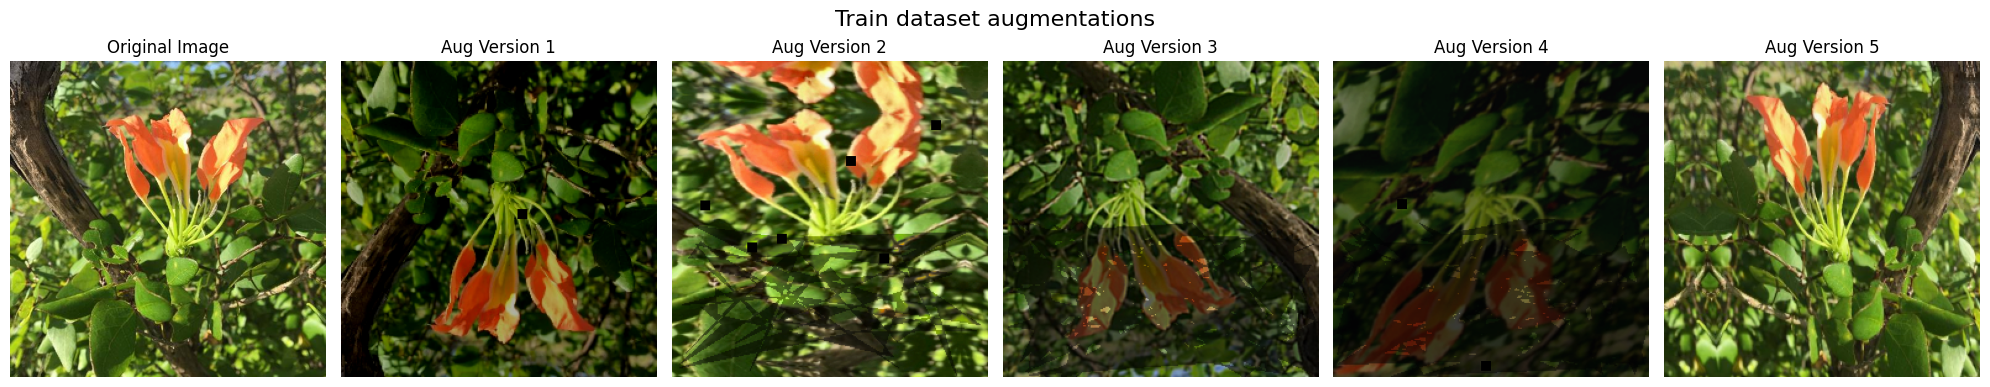

Feature                       Original       Aug Version 1  Aug Version 2  Aug Version 3  Aug Version 4  Aug Version 5  
WORLDCLIM_BI...               26.19          26.11          26.33          26.17          26.44          26.14          
WORLDCLIM_BI...               1509.79        1509.83        1509.99        1510.04        1509.84        1509.66        
WORLDCLIM_BI...               427.92         428.00         427.97         427.88         428.06         427.84         
WORLDCLIM_BI...               120.31         120.35         120.21         120.34         120.31         120.43         
WORLDCLIM_BI...               160.38         160.21         160.45         160.43         160.39         160.27         


In [ ]:
visualize_augmentations(dataset=train_dataset, title='Train dataset augmentations', idx=14, augment_times=5)

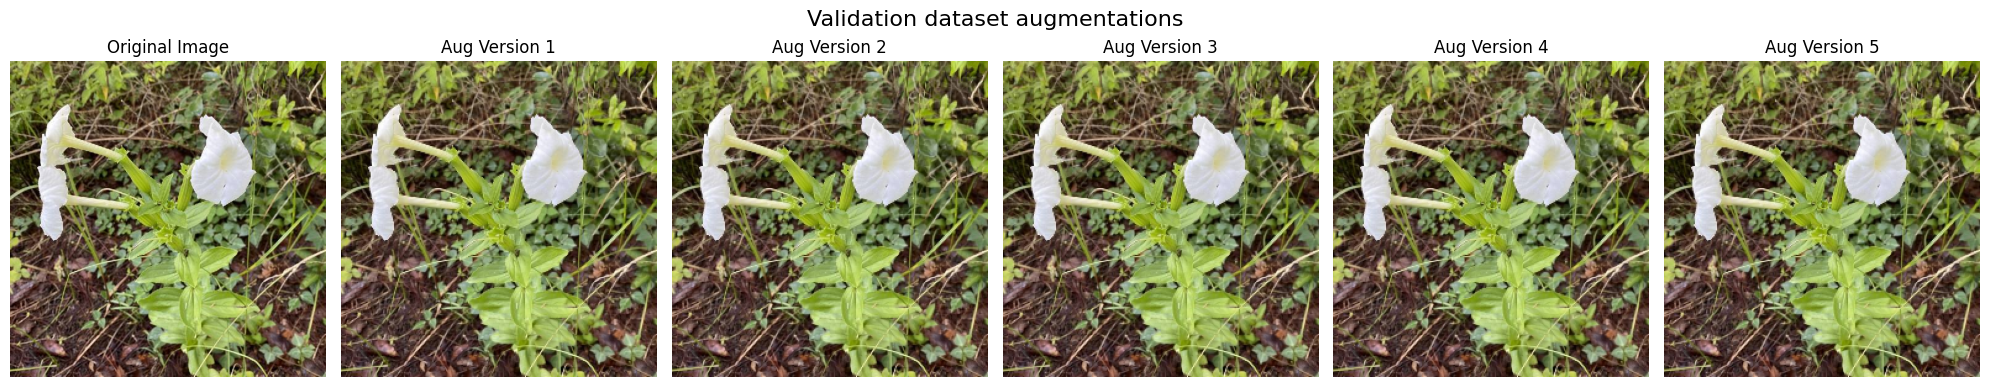

Feature                       Original       Aug Version 1  Aug Version 2  Aug Version 3  Aug Version 4  Aug Version 5  
WORLDCLIM_BI...               16.15          16.15          16.15          16.15          16.15          16.15          
WORLDCLIM_BI...               986.12         986.12         986.12         986.12         986.12         986.12         
WORLDCLIM_BI...               206.57         206.57         206.57         206.57         206.57         206.57         
WORLDCLIM_BI...               101.83         101.83         101.83         101.83         101.83         101.83         
WORLDCLIM_BI...               212.56         212.56         212.56         212.56         212.56         212.56         


In [ ]:
visualize_augmentations(dataset=val_dataset, title='Validation dataset augmentations', idx=14, augment_times=5)

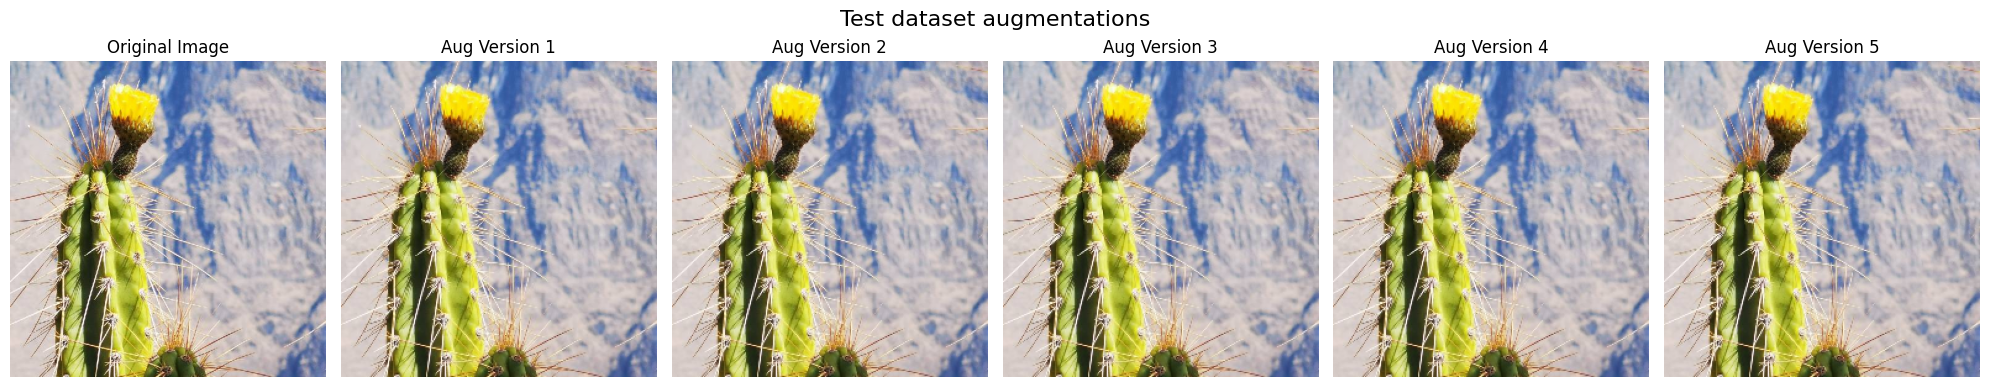

Feature                       Original       Aug Version 1  Aug Version 2  Aug Version 3  Aug Version 4  Aug Version 5  
WORLDCLIM_BI...               8.81           8.81           8.81           8.81           8.81           8.81           
WORLDCLIM_BI...               384.30         384.30         384.30         384.30         384.30         384.30         
WORLDCLIM_BI...               95.03          95.03          95.03          95.03          95.03          95.03          
WORLDCLIM_BI...               111.55         111.55         111.55         111.55         111.55         111.55         
WORLDCLIM_BI...               150.21         150.21         150.21         150.21         150.21         150.21         


In [ ]:
visualize_augmentations(dataset=test_dataset, title='Test dataset augmentations', idx=14, augment_times=5)

#**Baselines**

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

## Create dataloaders


In [ ]:
train_loader = DataLoader(train_dataset, batch_size= 32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size= 32, shuffle=False)

In [ ]:
class PlantTraitsPretrainedVGG16(nn.Module):
    def __init__(self):
        super().__init__()

        self.network = models.vgg16(pretrained=True)
        # Replace last layer
        self.network.classifier = nn.Sequential(
           nn.Linear(in_features=25088, out_features=4096, bias=True),
           nn.ReLU(inplace=True),
           nn.Dropout(p=0.5, inplace=False),
           nn.Linear(in_features=4096, out_features=2048, bias=True),
           nn.ReLU(inplace=True),
           nn.Dropout(p=0.5, inplace=False),
           nn.Linear(in_features=2048, out_features=12, bias=True),
           nn.LogSoftmax(dim=1)
        )

    def forward(self, xb):
        return self.network(xb)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = PlantTraitsPretrainedVGG16()
model = model.to(device)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 136MB/s]


PlantTraitsPretrainedVGG16(
  (network): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inpla

In [54]:
def r2_loss(output, target):
    target = torch.tensor(target)
    output = torch.tensor(output.values)
    target_mean = torch.mean(target)
    ss_tot = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return 1 - r2

In [ ]:
criterion_mse = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(model, train_loader, val_loader, criterion, optimizer, epochs=10):

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for images, meta_data, targets in train_loader:
            # Put data to GPU
            images, meta_data, targets = images.to(device), meta_data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * images.size(0)

        epoch_loss = epoch_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}, Loss: {epoch_loss}')


        model.eval()  # Set model to evaluation mode
        with torch.no_grad():
            epoch_loss = 0.0
            for images, meta_data, targets in val_loader:
                # Put data to GPU
                images, meta_data, targets = images.to(device), meta_data.to(device), targets.to(device)
                outputs = model(images)
                loss = criterion(outputs, targets)
                epoch_loss += loss.item() * images.size(0)

            epoch_loss = epoch_loss / len(val_loader.dataset)
            print(f'Epoch {epoch + 1}/{epochs} Validation Loss: {epoch_loss:.4f}')


def test_model(model, criterion, test_loader):
    model.eval()  # Set model to evaluation mode
    epoch_loss = 0.0
    with torch.no_grad():
       for images, meta_data, targets in val_loader:
            # Put data to GPU
            images, meta_data, targets = images.to(device), meta_data.to(device), targets.to(device)
            outputs = model(images)
            loss = criterion(outputs, targets)
            epoch_loss += loss.item() * images.size(0)

    test_loss = epoch_loss / len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}')


Train a
- ResNet (too slow)
- VGG
- Efficientnet

In [ ]:
train(model, train_loader, val_loader, r2_loss, optimizer, epochs=10)

Epoch 1, Loss: 1.0361871321996052
Epoch 1/10 Validation Loss: 1.0644
Epoch 2, Loss: 1.0346346398026882
Epoch 2/10 Validation Loss: 1.0644
Epoch 3, Loss: 1.0355254204896178
Epoch 3/10 Validation Loss: 1.0644
Epoch 4, Loss: 1.0355681495383076
Epoch 4/10 Validation Loss: 1.0644
Epoch 5, Loss: 1.0351414654580482
Epoch 5/10 Validation Loss: 1.0644
Epoch 6, Loss: 1.035777940267541
Epoch 6/10 Validation Loss: 1.0644
Epoch 7, Loss: 1.0356999632207229
Epoch 7/10 Validation Loss: 1.0644


In [ ]:
test_model(model, test_loader, r2_loss)

 # **MLP model**

# Data preparation

In [38]:
bemeno_valtozok = metadata_columns

In [25]:
celvaltozok = targets[:6]

###1. Gradient Boosting Machine

In [17]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

In [27]:
def train_GBM(df_train, df_val, df_test, bemeno_valtozok, celvaltozok, save_csv, need_explainability):

  model_gbm=GradientBoostingRegressor(n_estimators=400,max_depth=7,random_state=42)
  print("Training with GradientBoostingRegressor:")
  X_train = df_train[bemeno_valtozok]
  Y_train = df_train[celvaltozok]
  X_val = df_val[bemeno_valtozok]
  Y_val = df_val[celvaltozok]
  X_test = df_test[bemeno_valtozok]

  # Modell tanítása
  model_gbm.fit(X_train, Y_train)
  # Predikciók mentése
  predictions = model_gbm.predict(X_test)
  if save_csv:
      predictions.to_csv('results_GBM.csv', index=False)
  if need_explainability:
      print(model_gbm.feature_importances_)
  # Teljesítmény kiértékelése a validációs halmazon
  val_predictions = model_gbm.predict(X_val)
  r2_loss_gbm = r2_loss(Y_val, val_predictions)
  print("R2 Result of GradientBoostingMachine:", r2_loss_gbm)

## MLP Neural network

In [57]:
def train_MLP(df_train, df_val, df_test, bemeno_valtozok, celvaltozok, save_csv, need_explainability):

  model_nn = MLPRegressor(random_state=11, max_iter=500, learning_rate_init=0.005)
  print("Training with MLP:")
  X_train = df_train[bemeno_valtozok]
  Y_train = df_train[celvaltozok]
  X_val = df_val[bemeno_valtozok]
  Y_val = df_val[celvaltozok]
  X_test = df_test[bemeno_valtozok]

  # Modell tanítása
  model_nn.fit(X_train, Y_train)
  # Predikciók mentése
  predictions = model_nn.predict(X_test)
  if save_csv:
      predictions.to_csv('results_MLP.csv', index=False)
  #if need_explainability:
      #print(model_nn.feature_importances_)
  # Teljesítmény kiértékelése a validációs halmazon
  val_predictions = model_nn.predict(X_val)
  r2_loss_gbm = r2_loss(Y_val, val_predictions)
  print("R2 Result of MLP:", r2_loss_gbm)




## Train

In [34]:
 train_df, val_df, test_df = split_dataframe(train_df.sample(frac=0.2, random_state=1), test_df.sample(frac=0.2, random_state=1))

In [ ]:
for target in celvaltozok:
  print(f"Training for target: {target}")
  train_GBM(train_df, val_df, test_df, bemeno_valtozok, target, save_csv=False, need_explainability=False)

Training for target: X4_mean
Training with GradientBoostingRegressor:
R2 Result of GradientBoostingMachine: tensor(2.4824, dtype=torch.float64)
Training for target: X11_mean
Training with GradientBoostingRegressor:
R2 Result of GradientBoostingMachine: tensor(1.3595, dtype=torch.float64)
Training for target: X18_mean
Training with GradientBoostingRegressor:


In [58]:
train_MLP(train_df, val_df, test_df, bemeno_valtozok, celvaltozok, save_csv=False, need_explainability=False)

Training with MLP:
R2 Result of MLP: tensor(1.5202, dtype=torch.float64)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
